In [527]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =  (8,6)
#plt.rcParams["figure.figsize"] =  plt.rcParamsDefault["figure.figsize"]
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.special import ellipk as K1
from scipy.special import ellipe as K2 #Complete elliptic integral of the first kind

In [528]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data_corr_testing")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

# Analytic Calculations

In [529]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = np.log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    assert (T >= 0).all(), "Temperature is negative"
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = K1(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

def get_M_abs_analytic(T,B=None): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    if B is not None:
        assert (B == 0).all(), "Expression only valid for B = 0"
    M_abs_inner = 1-np.sinh(2/T)**-4
    M_abs = np.where(T>=T_c_analytic,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c_analytic
    return M_abs

def get_cV_analytic(T):
    assert (T >= 0).all(), "Temperature is negative"
    b = 2/T #Thermodynamic beta up to a multiplicative constant
    sinh_b = np.sinh(b)
    cosh_b = np.cosh(b)
    tanh_b = np.tanh(b)
    kappa_b = 2*tanh_b/cosh_b #Numerically more stable?
    K1_int = K1(kappa_b)
    K2_int = K2(kappa_b)
    K1_prime =  (K2_int/(1-kappa_b**2)-K1_int)/kappa_b 
    zero_term = sinh_b**-2
    first_term = -(sinh_b**-2+2*cosh_b**-2)*(2/np.pi)*K1_int
    second_term = 4/np.pi*(sinh_b**2-1)**2/(sinh_b*cosh_b**4)*K1_prime
    cV_analytic = -b**2/2 * (zero_term + first_term + second_term)
    return cV_analytic

def get_chi_analytic(T): #Need partial derivative of M with respect to B
    assert (T >= 0).all(), "Temperature is negative"
    return 0

# Fitting

In [530]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( np.abs(t)** crit_exp)

def hyperbola_exp_decay_fit(d, R_0, d_c, xi):
   return np.where(d>d_c,R_0 * np.exp(d/-xi),R_0*d_c/d* np.exp(d_c/-xi)) 

def hyperbola_exp_decay_offset_fit(d, R_0, d_c, xi, R_limit):
   return np.where(d>d_c,R_0 * np.exp(d/-xi) + R_limit,(R_0 * np.exp(d_c/-xi) + R_limit)*d_c/d) 

def linearized_power_law_fit(ln_X, k, X_c, crit_exp):
    return  np.log(k) + crit_exp * (np.log(np.exp(ln_X)-X_c)-np.log(X_c))

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)

In [531]:
def fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp = 1.0,  from_above = True, print_summary = True, maxfev=10000):
    assert fitting_model is not None, "No fitting model provided"
    if fitting_model is power_law_fit:
        bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp  
        param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    elif fitting_model is hyperbola_exp_decay_fit:
        bounds = to_tuple([(0, np.inf), (0, np.inf), (0, np.inf)])  #Bounds for R_0, d_c, xi
        param_ests = [1, 1, 1] #Initial values for R_0, d_c, xi
    elif fitting_model is hyperbola_exp_decay_offset_fit:
        bounds = to_tuple([(0, np.inf), (0, np.inf), (0, np.inf), (0,1)])  #Bounds for R_0, d_c, xi, R_shift
        param_ests = [1, 5, 1, 0.002] #Initial values for R_0, d_c, xi, R_shift
    else:
        raise ValueError("Unsupported fitting model provided")
    
    if X_c is not None:
        if from_above: #Only use X data greater than or equal to X_c
            X_filt = X[X >= X_c]
            Y_mean_filt = Y_mean[X >= X_c]
            Y_std_filt = Y_std[X >= X_c]             
        else: #Only use X data less than or equal to X_c
            X_filt = X[X <= X_c]
            Y_mean_filt = Y_mean[X <= X_c]
            Y_std_filt = Y_std[X <= X_c]
    else:
        X_filt = X
        Y_mean_filt = Y_mean
        Y_std_filt = Y_std

    popt, pcov = curve_fit(fitting_model, X_filt, Y_mean_filt, sigma=Y_std_filt, p0=param_ests,bounds=bounds, maxfev=maxfev)

    Y_mean_filt_fit = fitting_model(X_filt,*popt)      
    Y_mean_filt_res = Y_mean_filt - Y_mean_filt_fit
    Y_mean_filt_norm_res = Y_mean_filt_res/Y_std_filt
    N_filt = len(Y_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(Y_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    param_errs = np.sqrt(np.diag(pcov))
    param_text = [f"{param:.2f} ± {err:.2f}" for param, err in zip(popt, param_errs)]
    param_text = ", ".join(param_text)

    if print_summary:
        print(f"Fitting model: {fitting_model.__name__}")
        print(f"Fitting parameters: {popt}")

        print(f"Parameter errors: {param_errs}")
        print(f"Covariance matrix: {pcov}")
        
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")  

    legend_text = "Fit"+"\n"
    legend_text += param_text + "\n"
    legend_text += f"Reduced chi squared: {reduced_chi_squared:.2f}"

    return popt, pcov, X_filt, Y_mean_filt_norm_res, legend_text   

## Obsolete due to fit

In [532]:
'''
def T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")
    return popt, pcov, X_mean_filt_norm_res   
'''

'\ndef T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):\n    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    \n    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp\n    if from_above: #Approach critical temperature from above\n        T_filt = T[T >= T_c_analytic]\n        X_mean_filt = X_mean[T >= T_c_analytic]\n        X_std_filt = X_std[T >= T_c_analytic]                \n    else: #Approach critical temperature from below\n        T_filt = T[T <= T_c_analytic]\n        X_mean_filt = X_mean[T <= T_c_analytic]\n        X_std_filt = X_std[T <= T_c_analytic] \n\n    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)\n\n    X_mean_filt_fit = power_law_fit(T_filt,*popt)      \n    X_mean_filt_res = X_mean_filt - X_mean_filt_fit\n    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt\n    N_filt = len(X_me

# Single CSV Calculations and Plotting

## Single CSV Calculations

In [533]:
#Settings for the analysis
selected_trial = -1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
T, E_mean, E_std, M_mean, M_std= data_selected_trial.T.to_numpy()
corr_data = corr_selected_trial.T.to_numpy()
T_corr = corr_data[0]
assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
R_data = corr_data[1:]
R_mean_matrix, R_std_matrix = np.array([R_data[i] for i in range(0,len(R_data),2)]), np.array([R_data[i] for i in range(1,len(R_data),2)])

cV = np.square(E_std)/np.square(T) #In units where k_B = 1
chi = np.square(M_std)/T #In units where k_B = 1
#cV_mean will need to come from combined best estimate: average of cV over CSVs (weighted by cV itself because this is the best estimate for the error of each cV?)
#cV_std will need to come from the standard error of standard deviation
#Same for chi_mean, chi_std

#General calculations
N = len(T)
T_min, T_max = T.min(), T.max()
T_analytic = np.linspace(T_min, T_max, 1000)

#Logarithmic scale calculations
ln_T = np.log(T)
ln_T_analytic = np.linspace(np.log(T_min), np.log(T_max), 1000)
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(np.log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(np.log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

In [534]:
def create_plot(X, X_symbol=r"?", X_name=r"???", X_c = None, X_c_symbol = None, Y_mean=None, Y_std=None, Y_symbol=r"?", Y_name=r"???", get_Y_analytic=None, log_plot = True, fitting_model=None, expected_crit_exp = 1.0, from_above=True):   
    #Error handling
    assert Y_mean is not None, "No vertical data given"
    if Y_std is None: #No error is given
        Y_std = np.zeros_like(Y_mean)
        with_errorbar = False
    else: #Check if error is identically 0
        with_errorbar = not (Y_std == np.zeros_like(Y_std)).all() 
    if not with_errorbar:
        print("*Proceeding assuming no error (unphysical)")
    if X_c_symbol is None:
        X_c_symbol = X_symbol     

    if fitting_model is not None: #Work in progress: need to be careful with signs        
        popt, pcov, X_fit, Y_mean_norm_res_fit, fit_legend_text=  fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp=expected_crit_exp, from_above=from_above) 
             
    if get_Y_analytic is not None:
        X_min, X_max = np.min(X), np.max(X)
        X_analytic = np.linspace(X_min, X_max, 1000)
        Y_mean_analytic = get_Y_analytic(X_analytic) #T_analytic is of high spatial frequency to produce a smooth curve
    else:
        X_analytic = None
        Y_mean_analytic = None

    if fitting_model is not None:
        X_fit_min, X_fit_max = np.min(X_fit), np.max(X_fit)
        X_fit_smooth = np.linspace(X_fit_min, X_fit_max, 1000) #X_fit_smooth is of high spatial frequency to produce a smooth curve
        Y_mean_fit = fitting_model(X_fit_smooth, *popt)
    else:
        X_fit_smooth = None
        Y_mean_fit = None

    if log_plot: #Calculations specific and plotting labels specific to using log plot
        ln_X_fit = np.log(X_fit)
        ln_X = np.log(X)
        if X_c is not None:
            ln_X_c = np.log(X_c)
        ln_Y_mean = np.log(Y_mean)
        ln_Y_std = get_ln_std(Y_mean, Y_std)

        if get_Y_analytic is not None or fitting_model is not None: #If present, get high density ln_X called ln_X_smooth                       
            ln_X_smooth = np.linspace(np.log(X_min), np.log(X_max), 1000)
        else:
            ln_X_smooth = None

        if get_Y_analytic is not None:
            ln_X_analytic = np.linspace(np.log(X_min), np.log(X_max), 1000)
            ln_Y_mean_analytic = np.log(get_Y_analytic(np.exp(ln_X_smooth)))
        else:
            ln_X_analytic = None
            ln_Y_mean_analytic = None

        if fitting_model is not None:
            ln_X_fit_smooth = np.linspace(np.log(X_fit_min), np.log(X_fit_max), 1000)
            ln_Y_mean_fit = np.log(fitting_model(np.exp(ln_X_smooth), *popt))
        else:
            ln_X_fit_smooth = None
            ln_Y_mean_fit = None            
            
        using = [ln_X,ln_X_analytic, ln_X_fit_smooth,ln_X_c, ln_Y_mean, ln_Y_std, ln_Y_mean_analytic, ln_Y_mean_fit]
        X_label = f'$ln({X_symbol})$'
        Y_label = f'$ln({Y_symbol})$'
    else: #Calculations specific and plotting labels specific to non log plots     
        using = [X,X_analytic, X_fit_smooth,X_c,Y_mean, Y_std, Y_mean_analytic, Y_mean_fit] #No analytic curve for non-power-law fits
        X_label = f'${X_symbol}$'    
        Y_label = f'${Y_symbol}$'    
    fit_ax = None
    if get_Y_analytic is not None: #Calculations and plotting specific to having an analytic model
        #Residual calculations
        Y_mean_res_analytic = Y_mean - get_Y_analytic(X)
        Y_std_res_analytic = Y_std
        Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std
        Y_std_norm_res_analytic = 1 #Always 1 since X_std_norm_res_analytic = X_std_res_analytic / X_std = 1

        #Goodness of fit to analytic model
        degrees_of_freedom_analytic = N #Relies on global variable in cell above
        chi_squared_analytic= np.sum(np.square(Y_mean_norm_res_analytic)) 
        reduced_chi_squared_analytic = chi_squared_analytic / degrees_of_freedom_analytic     
        print(f"Reduced chi squared (analytic): {reduced_chi_squared_analytic}")

        #Plotting specific to having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(3,1, constrained_layout=True, sharex=True, height_ratios=[2, 1, 1])  
            fit_ax = axs [2]          
        else:
            fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], Y_mean_norm_res_analytic, yerr=Y_std_norm_res_analytic, fmt='o', color='blue', label='Residuals (analytic)')
        if X_c is not None:
            res_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')      
        ax.plot(using[1], using[6], color='orange', label='Analytic') 
        if fitting_model is None:           
            res_ax.set_xlabel(X_label)
        res_ax.set_ylabel('Normalized Residual (analytic)')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else: #Plotting specific to not having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(2,1, constrained_layout = True, sharex=True, height_ratios=[2, 1])
            fit_ax = axs[1]
            ax = axs[0]
        else:
            fig, ax = plt.subplots(1,1)
            ax.set_xlabel(X_label)

    if fitting_model is not None:
        ax.plot(using[2], using[7], color='green', label=fit_legend_text) #Plot the fit
        Y_std_norm_res_fit = 1       
        fit_ax.set_ylabel('Normalized Residual (fit)')
        fit_ax.errorbar(X_fit, Y_mean_norm_res_fit, yerr= Y_std_norm_res_fit, fmt='o', color='blue', label='Residuals (fit)')
        fit_ax.axhline(0, color='green', linestyle='--')
        fit_ax.set_xlabel(X_label)
        if X_c is not None:
            fit_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)') 
    
    #Plotting common to all variants    
    if with_errorbar:
        ax.errorbar(x=using[0], y=using[4], yerr=using[5], fmt='o', color='blue', label='Simulated')
    else:        
        ax.errorbar(x=using[0], y=using[4], fmt='o', yerr=None, color='blue', label='Simulated')
    ax.set_ylabel(Y_label)
    if X_c is not None:
        ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{Y_name} vs {X_name}')
    plt.show()

In [535]:
def create_T_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_fit, expected_crit_exp = 1.0, from_above=True):   
   create_plot(X=T, X_symbol=r"k_B T / J", X_name=r"Temperature", X_c = T_c_analytic, X_c_symbol="T", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)

In [536]:
def create_d_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=hyperbola_exp_decay_offset_fit, expected_crit_exp = 1.0, from_above=True):   
   create_plot(X=[i for i in range(1,len(mean)+1)], X_symbol=r"x", X_name=r"Normalized Separation Distance", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)
   

## Single CSV Plots

Reduced chi squared (analytic): 0.93053827925967


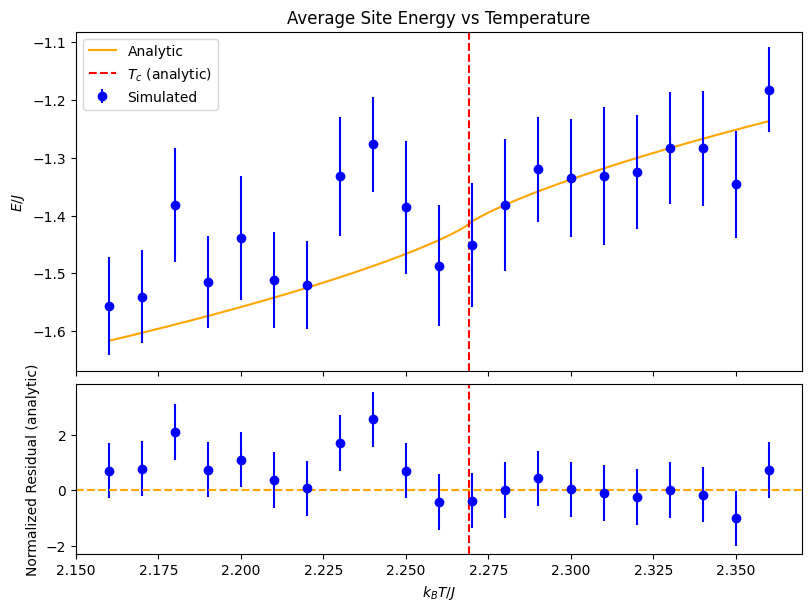

In [537]:
create_T_plot(E_mean, E_std, symbol = 'E/J', name = 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic, fitting_model=None)

Fitting model: power_law_fit
Fitting parameters: [1.21421984 2.35443657 0.17440386]
Parameter errors: [5.29637987 1.79446338 2.29961198]
Covariance matrix: [[28.05163972  9.34036482 12.15758757]
 [ 9.34036482  3.22009881  4.09346147]
 [12.15758757  4.09346147  5.28821524]]
Reduced chi squared (fit): 2.0783001625546285
Reduced chi squared (analytic): 8.013460559403713


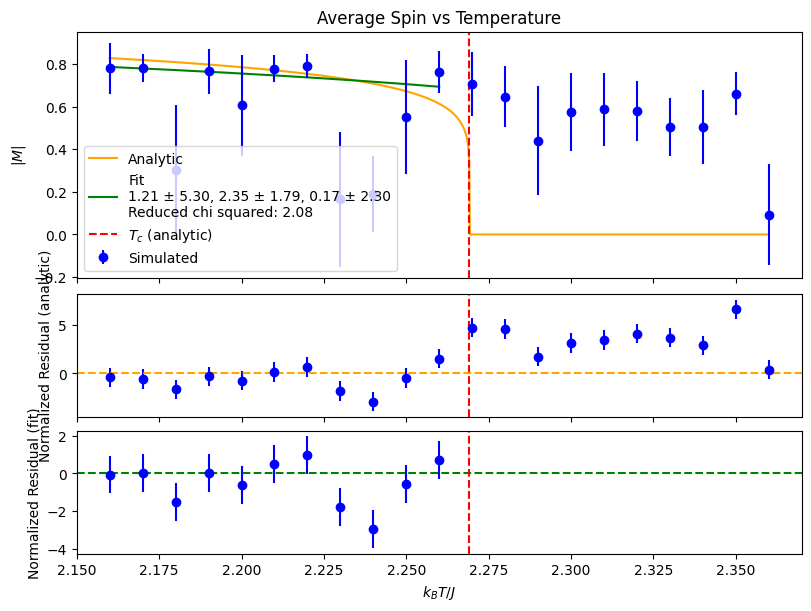

In [538]:
create_T_plot(np.abs(M_mean), M_std, symbol='|M|', name='Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, from_above = False)

*Proceeding assuming no error (unphysical)
Reduced chi squared (analytic): inf


C:\Users\17757\AppData\Local\Temp\ipykernel_30228\303320491.py:72: RuntimeWarning: divide by zero encountered in divide
  Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std


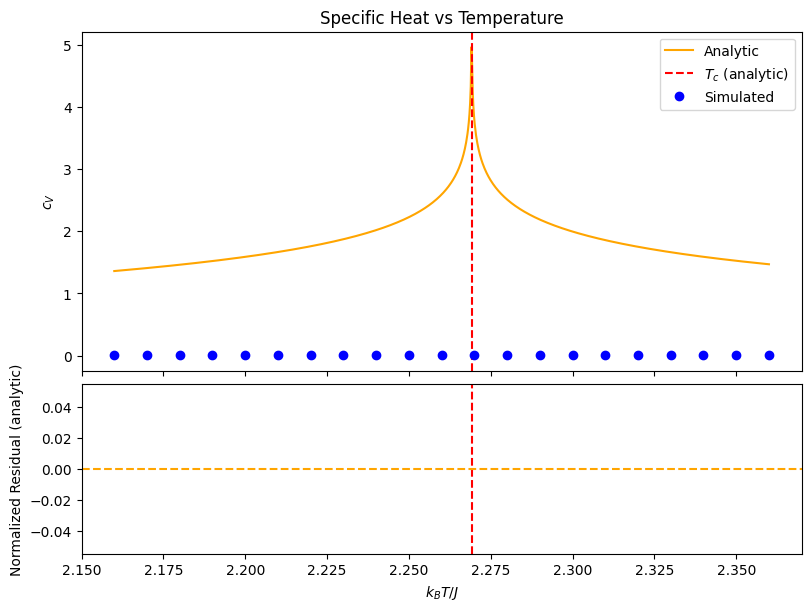

In [539]:
create_T_plot(cV, symbol='c_V', name='Specific Heat', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

# Autocorrelation Single

In [540]:
show_T_scan_at_fixed_d = False
if show_T_scan_at_fixed_d:
    for d, (R_mean, R_std) in enumerate(zip(R_mean_matrix, R_std_matrix), start=1):
        create_T_plot(mean=R_mean, std=R_std, symbol=f'R({d})', name=f'Autocorrelation Function (d = ${d}$)', log_plot = False, expected_crit_exp=0.0, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [2.70597192e-01 3.00000004e+00 2.55137790e-01 8.06170937e-04]
Parameter errors: [3.34035099e+05 2.49770322e+03 2.01022781e+04 1.01396936e-04]
Covariance matrix: [[ 1.11579448e+11 -8.34191882e+08 -6.71475143e+09  1.36538158e+01]
 [-8.34191882e+08  6.23852136e+06  5.01957615e+07 -1.00820252e-01]
 [-6.71475143e+09  5.01957615e+07  4.04101586e+08 -8.25131213e-01]
 [ 1.36538158e+01 -1.00820252e-01 -8.25131213e-01  1.02813387e-08]]
Reduced chi squared (fit): 0.29642467796531335


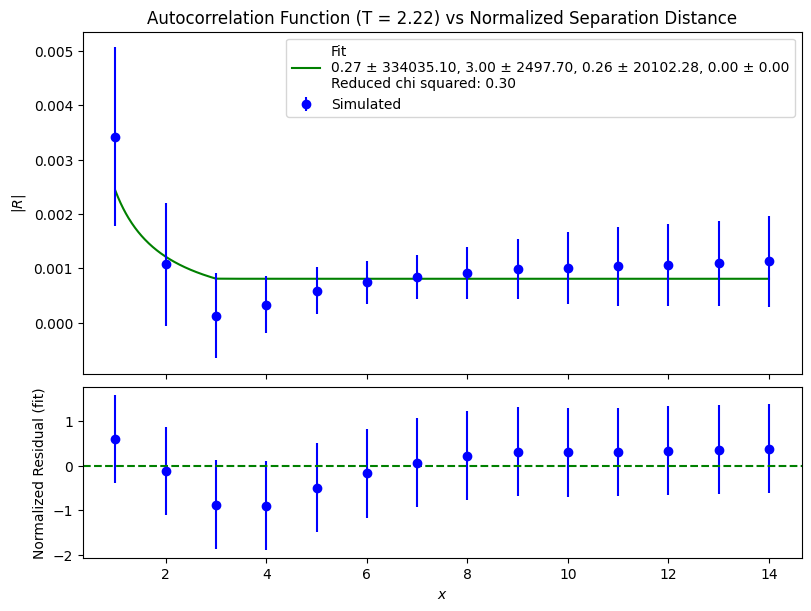

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [4.51086596e+12 3.98058321e+00 1.11189228e-01 2.36484997e-03]
Parameter errors: [4.03546337e-17 3.53672760e-01 8.82978123e-03 6.15992531e-04]
Covariance matrix: [[ 1.62849646e-33 -1.42530543e-17 -3.27367948e-19  1.15405667e-22]
 [-1.42530543e-17  1.25084421e-01  2.92928843e-03 -6.64995066e-06]
 [-3.27367948e-19  2.92928843e-03  7.79650366e-05 -1.09320494e-06]
 [ 1.15405667e-22 -6.64995066e-06 -1.09320494e-06  3.79446799e-07]]
Reduced chi squared (fit): 1.8418225450993724


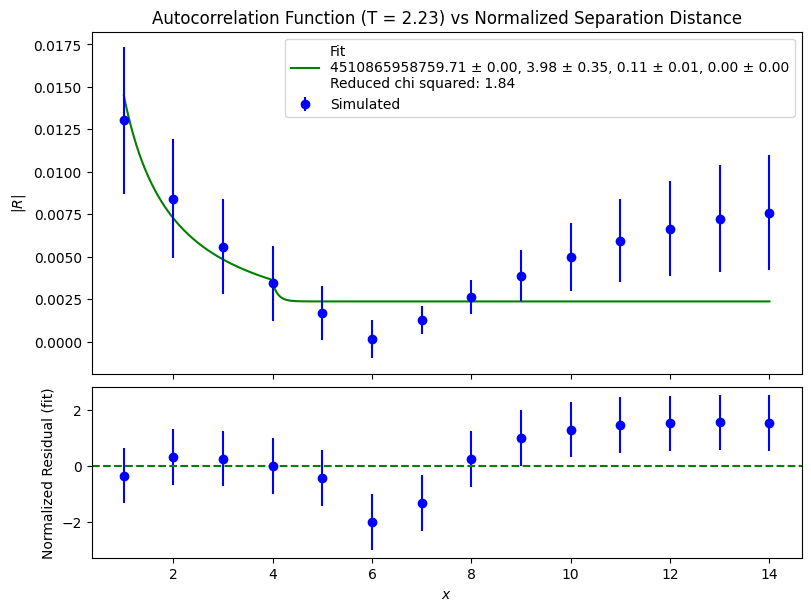

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [1.19049403e-01 4.18107527e+00 1.08304014e-01 3.54679278e-03]
Parameter errors: [0.00000000e+00 1.07862330e+00 0.00000000e+00 6.43117925e-04]
Covariance matrix: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.16342823e+00  0.00000000e+00 -4.87565986e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.87565986e-04  0.00000000e+00  4.13600666e-07]]
Reduced chi squared (fit): 3.1392459199256795


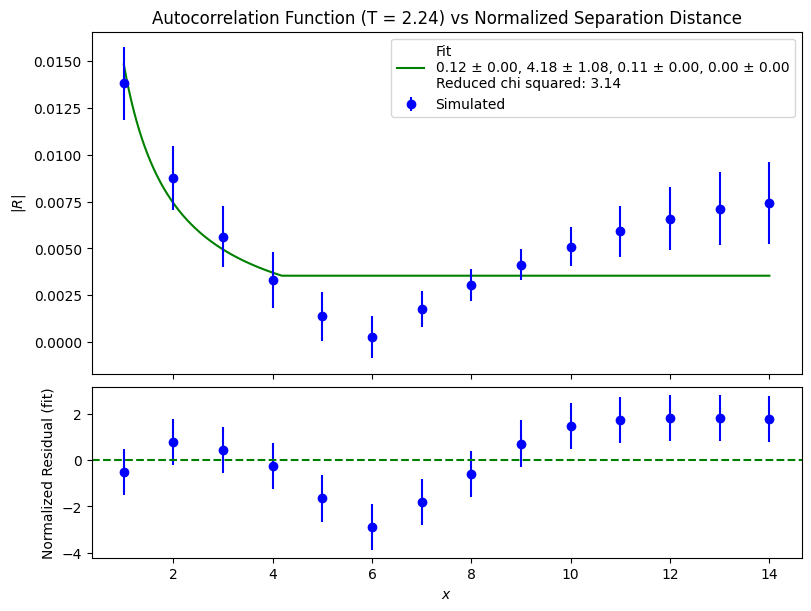

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [5.46224476e-01 5.00000000e+00 1.78704114e-02 1.53825047e-03]
Parameter errors: [0.00000000e+00 1.81477511e+00 0.00000000e+00 3.37254756e-04]
Covariance matrix: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.29340869e+00  0.00000000e+00 -3.70977585e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.70977585e-04  0.00000000e+00  1.13740771e-07]]
Reduced chi squared (fit): 0.5641650326901997


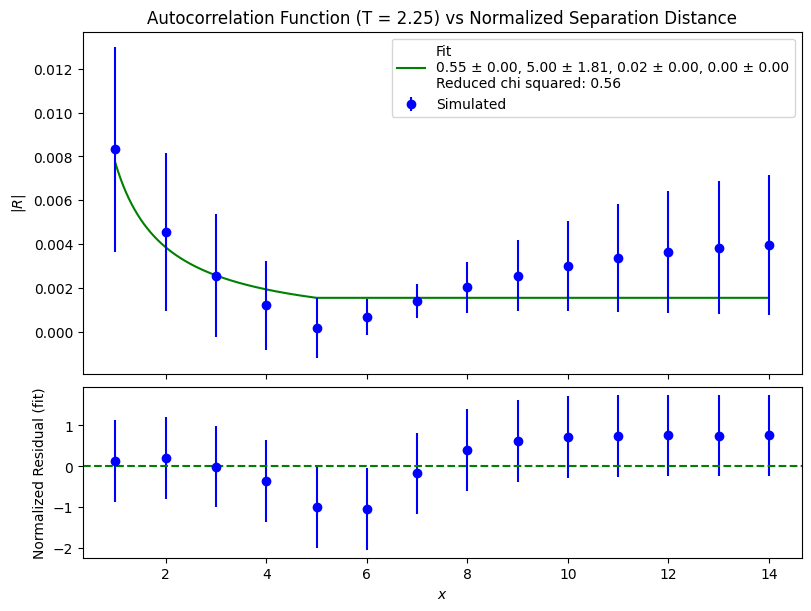

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [2.39333880e-01 3.00000030e+00 2.26505221e-01 8.91840993e-04]
Parameter errors: [4.58011454e+06 6.83984793e+03 2.45652583e+05 1.42627821e-04]
Covariance matrix: [[ 2.09774492e+13 -3.13260873e+10 -1.12511219e+12  3.44075656e+02]
 [-3.13260873e+10  4.67835197e+07  1.68011196e+09 -5.10726037e-01]
 [-1.12511219e+12  1.68011196e+09  6.03451917e+10 -1.84917452e+01]
 [ 3.44075656e+02 -5.10726037e-01 -1.84917452e+01  2.03426952e-08]]
Reduced chi squared (fit): 0.28027237393760296


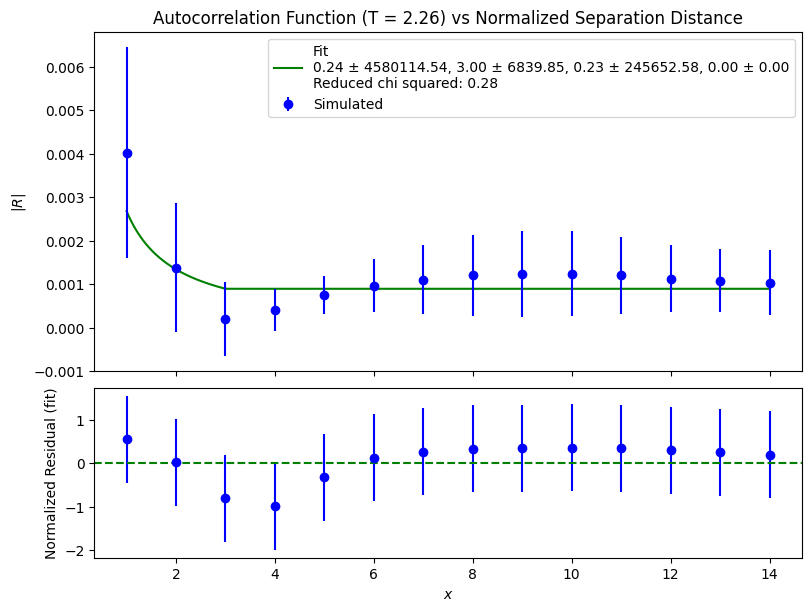

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [1.56933806e-01 3.89996977e+00 5.85008665e-02 1.12009044e-03]
Parameter errors: [0.00000000e+00 1.27124077e+00 0.00000000e+00 1.68860306e-04]
Covariance matrix: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.61605310e+00  0.00000000e+00 -9.92803494e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.92803494e-05  0.00000000e+00  2.85138031e-08]]
Reduced chi squared (fit): 0.28629431158731655


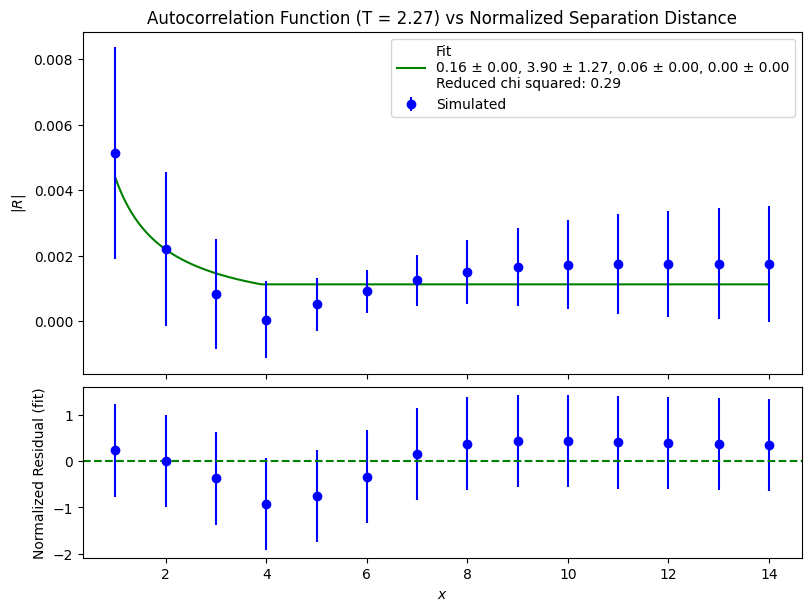

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [2.72898385e-01 3.99999571e+00 2.57032090e-01 1.36574142e-03]
Parameter errors: [6.28094573e+05 2.43568310e+00 3.80459358e+04 2.56035083e-04]
Covariance matrix: [[ 3.94502793e+11 -5.89273356e+04 -2.38958658e+10  7.55840532e+01]
 [-5.89273356e+04  5.93255215e+00  3.03104295e+03 -2.93455154e-06]
 [-2.38958658e+10  3.03104295e+03  1.44749323e+09 -4.59700487e+00]
 [ 7.55840532e+01 -2.93455154e-06 -4.59700487e+00  6.55539638e-08]]
Reduced chi squared (fit): 0.47834909791328917


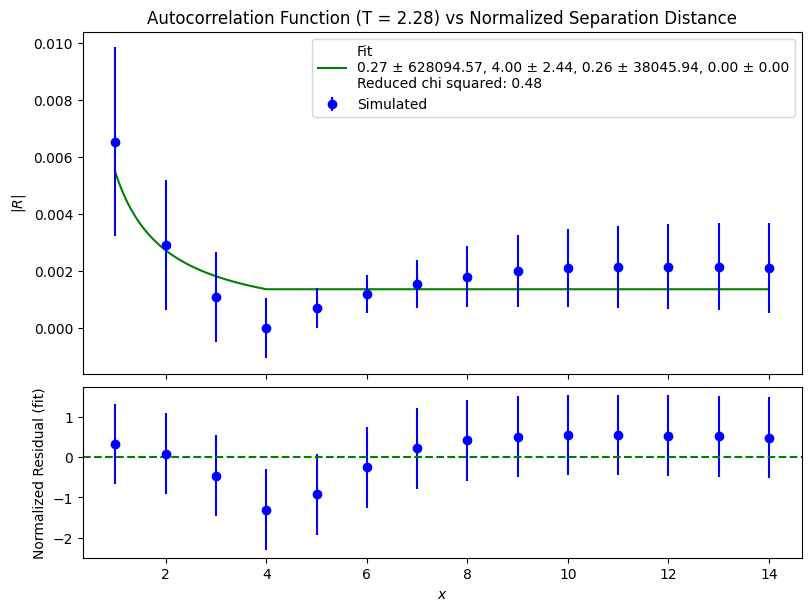

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [8.80089191e-02 4.64531626e+00 9.06377451e-02 2.07006765e-03]
Parameter errors: [0.00000000e+00 1.47402960e+00 0.00000000e+00 3.91587617e-04]
Covariance matrix: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.17276325e+00  0.00000000e+00 -3.44103151e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.44103151e-04  0.00000000e+00  1.53340862e-07]]
Reduced chi squared (fit): 0.8820317633216426


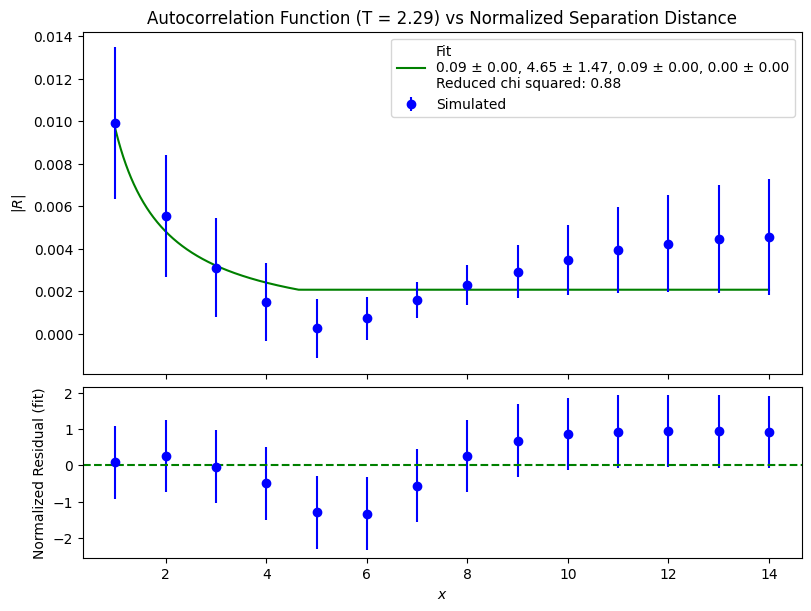

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [2.84294002e-01 4.00000000e+00 2.79011016e-01 1.71598024e-03]
Parameter errors: [7.18089532e+06 1.98635679e+03 3.93566555e+05 3.45927272e-04]
Covariance matrix: [[ 5.15652576e+13 -1.42593860e+10 -2.82610505e+12  1.22460853e+03]
 [-1.42593860e+10  3.94561330e+06  7.81383548e+08 -3.32513453e-01]
 [-2.82610505e+12  7.81383548e+08  1.54894633e+11 -6.74293906e+01]
 [ 1.22460853e+03 -3.32513453e-01 -6.74293906e+01  1.19665677e-07]]
Reduced chi squared (fit): 0.5749504079186545


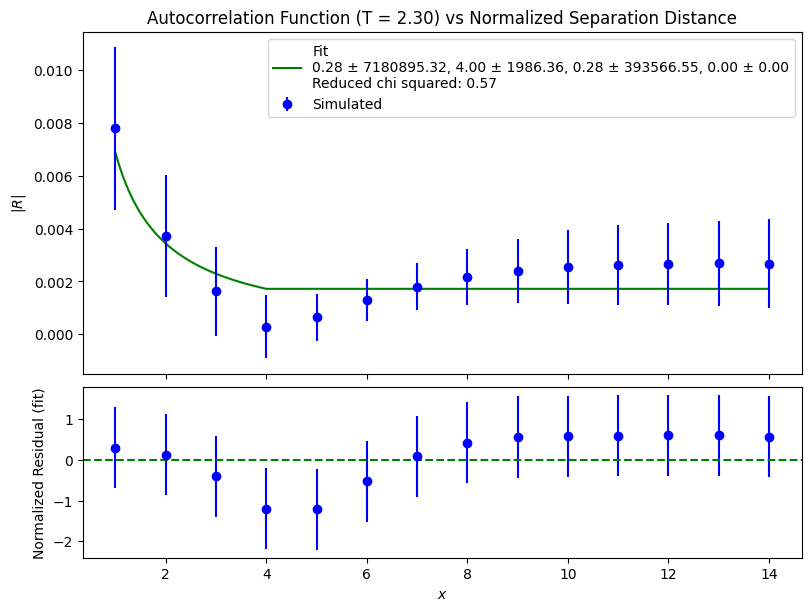

Fitting model: hyperbola_exp_decay_offset_fit
Fitting parameters: [2.49490855e-01 3.99999993e+00 2.67319311e-01 1.59732873e-03]
Parameter errors: [3.60776794e+05 2.29058416e+00 2.58571987e+04 2.87480533e-04]
Covariance matrix: [[ 1.30159895e+11 -2.08207550e+04 -9.32842468e+09  4.43472227e+01]
 [-2.08207550e+04  5.24677578e+00  1.13024209e+03  1.25517322e-06]
 [-9.32842468e+09  1.13024209e+03  6.68594726e+08 -3.19431146e+00]
 [ 4.43472227e+01  1.25517322e-06 -3.19431146e+00  8.26450569e-08]]
Reduced chi squared (fit): 0.6109942887005252


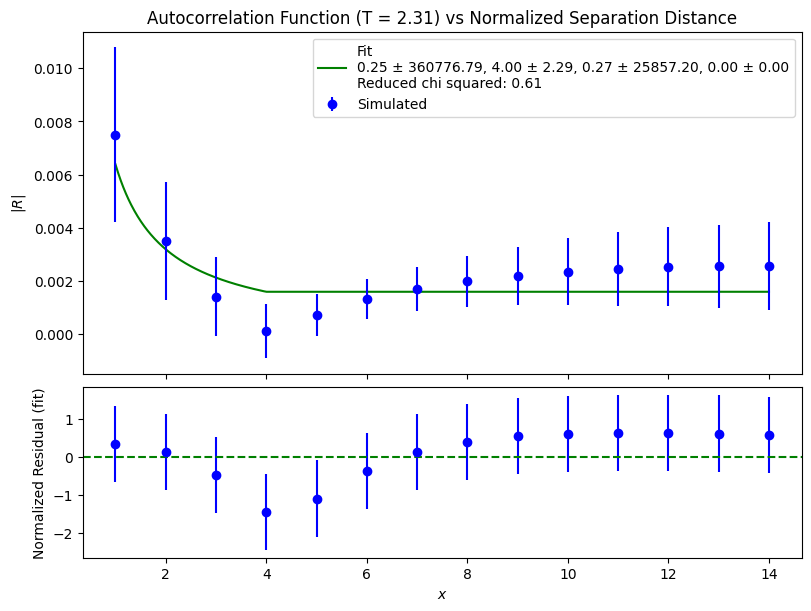

In [541]:
for T_index, (R_mean, R_std) in enumerate(zip(R_mean_matrix.T, R_std_matrix.T)):
    T_current = T[T_index]
    if np.abs(T_current - T_c_analytic) < 0.05:
        create_d_plot(mean=np.abs(R_mean), std=R_std, symbol='|R|', name= f'Autocorrelation Function (T = {T_current:.2f})', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

# Multiple CSV Calculations and Plotting

## Pandas to Numpy

In [542]:
#All files in directory
E_means = []
E_stds = []
M_means = []
M_stds = []
R_means = []
R_stds = []
cVs = []
chis = []
for (data,corr) in zip(datas,corrs):
    T, E_mean, E_std, M_mean, M_std= data.T.to_numpy()
    corr_data = corr.T.to_numpy()
    T_corr = corr_data[0]
    assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
    R_data = corr_data[1:]
    R_mean, R_std = [R_data[i] for i in range(0,len(R_data),2)], [R_data[i] for i in range(1,len(R_data),2)]
    cV = np.square(E_std)/np.square(T) #In units where k_B = 1
    chi = np.square(M_std)/T #In units where k_B = 1
    E_means.append(E_mean)
    E_stds.append(E_std)
    M_means.append(M_mean)
    M_stds.append(M_std)
    R_means.append(R_mean)
    R_stds.append(R_std)
    cVs.append(cV)
    chis.append(chi)

E_weights = np.array(E_stds)**-2
E_est = np.average(E_means, axis=0, weights=E_weights)
E_est_std = 1/np.sqrt(np.sum(E_weights,axis=0))
M_weights = np.array(M_stds)**-2
M_est = np.average(M_means, axis=0, weights=M_weights)
M_est_std = 1/np.sqrt(np.sum(M_weights,axis=0))
M_abs_est = np.average(np.abs(M_means), axis=0, weights=M_weights)

R_weights = np.array(R_stds)**-2
R_est = np.average(R_means, axis=0, weights=R_weights)
R_est_std = 1/np.sqrt(np.sum(R_weights,axis=0))
cV_mean = np.mean(cVs, axis=0)
cV_std = np.std(cVs, axis=0)/np.sqrt(len(cVs)) #Standard error of the mean
chi_mean = np.mean(chis, axis=0)
chi_std = np.std(chis, axis=0)/np.sqrt(len(chis)) #Standard error of the mean

## Plotting

Fitting model: power_law_fit
Fitting parameters: [0.30905718 2.31675516 2.8866843 ]
Parameter errors: [2453746.45770562    3842.45856898 1987441.72022618]
Covariance matrix: [[ 6.02087168e+12 -1.61071231e+09  4.87399531e+12]
 [-1.61071231e+09  1.47644879e+07 -1.34017222e+09]
 [ 4.87399531e+12 -1.34017222e+09  3.94992459e+12]]
Reduced chi squared (fit): 260.22484606738425
Reduced chi squared (analytic): 0.9305382792596707


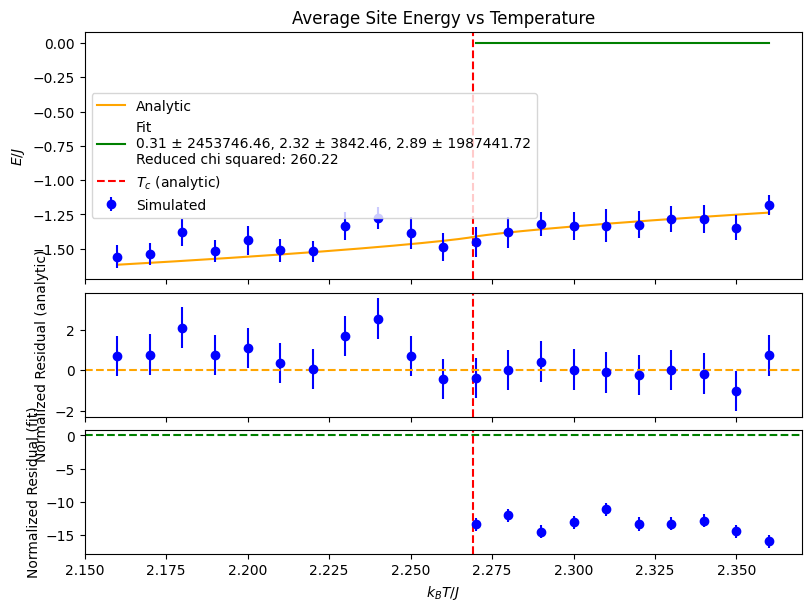

In [543]:
create_T_plot(E_est, E_est_std, 'E/J', 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic)

Fitting model: power_law_fit
Fitting parameters: [ 0.43415708  2.26832994 -0.06761325]
Parameter errors: [0.24669837 0.01444799 0.15084257]
Covariance matrix: [[0.06086009 0.00318457 0.03679359]
 [0.00318457 0.00020874 0.00202892]
 [0.03679359 0.00202892 0.02275348]]
Reduced chi squared (fit): 0.7880223273715465
Reduced chi squared (analytic): 8.013460559403713


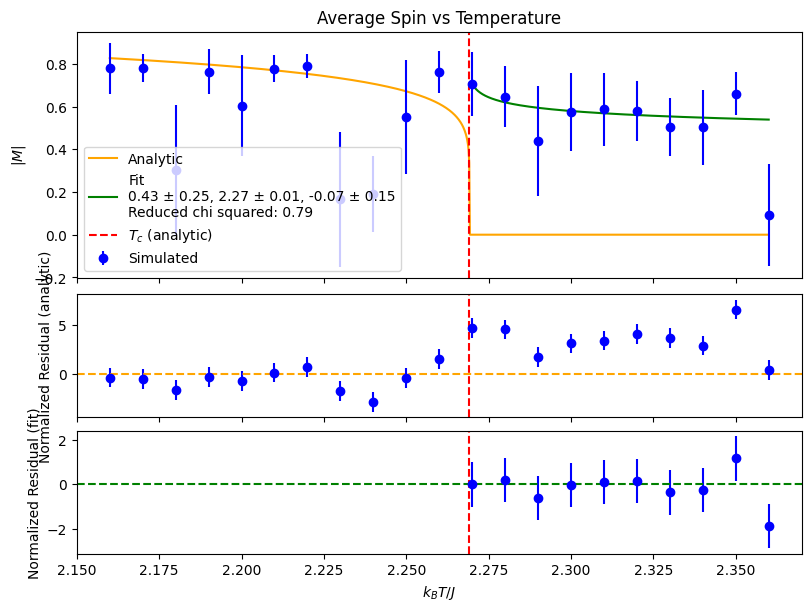

In [544]:
create_T_plot(np.abs(M_abs_est), M_est_std, '|M|', 'Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic)

In [545]:
print(f"cV_mean: {cV_mean}")

cV_mean: [0.0015625  0.00138598 0.00205198 0.00131965 0.00240041 0.00142363
 0.00117987 0.00211082 0.00135855 0.00260044 0.00214072 0.00226361
 0.00252099 0.00157584 0.00195925 0.00266017 0.00182223 0.00170425
 0.00181811 0.00156589 0.00097976]


In [546]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

*Proceeding assuming no error (unphysical)


c:\Users\17757\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


ValueError: Residuals are not finite in the initial point.

*Proceeding assuming no error (unphysical)


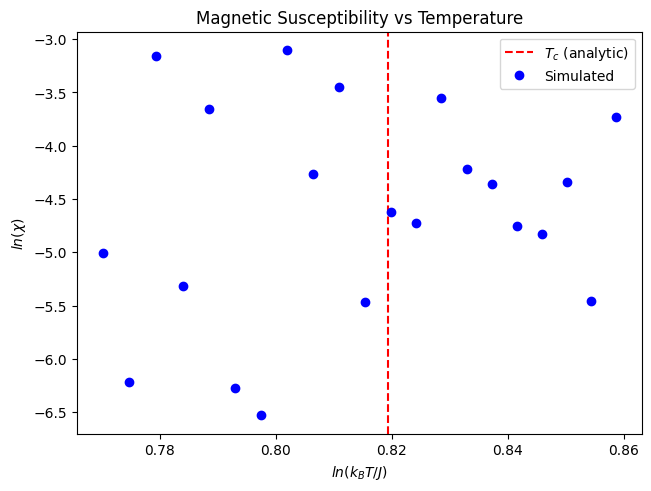

In [87]:
create_T_plot(chi_mean, chi_std, symbol= r'\chi', name='Magnetic Susceptibility', log_plot = True, expected_crit_exp=-7/4) #zeros_like forces std to default which is then propagated for ln

*Proceeding assuming no error (unphysical)


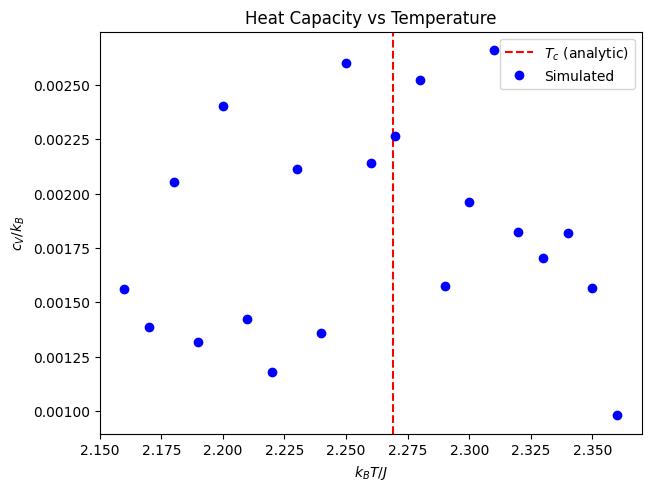

In [88]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

## Analysis of Burn-In Time and Annealing
 n_transfer = 3000, inp['n_analyze']  = 5000, inp['n_burnin']   =  [0,100,200,300,400,500,600,700,10000]

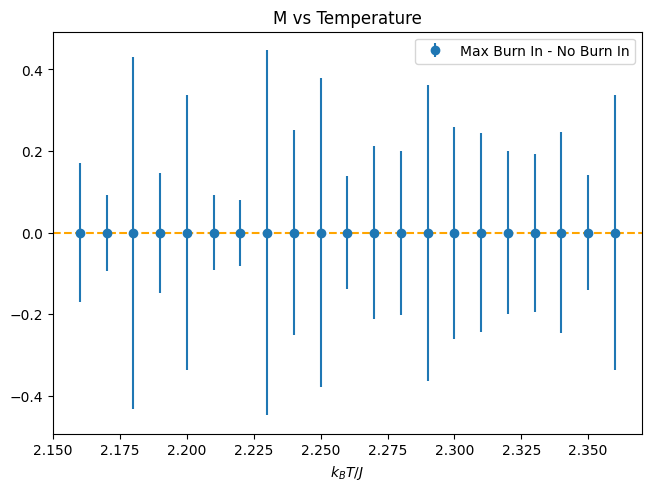

In [89]:
fig, ax = plt.subplots(1,1, constrained_layout=True, sharex=True)
X_mean_first = np.abs(M_means[0])
X_std_first = M_stds[0]
X_mean_last = np.abs(M_means[-1])
X_std_last = M_stds[-1]
X_mean_diff = X_mean_last - X_mean_first
X_std_diff = np.sqrt(X_std_last**2 + X_std_first**2) #Assuming independent errors
ax.errorbar(x=T, y=X_mean_diff, yerr=X_std_diff, fmt='o', label='Max Burn In - No Burn In')
ax.axhline(0, color='orange', linestyle='--')
ax.set_xlabel('$k_BT / J$')
'''
res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
ax.plot(using[1], using[5], color='orange', label='Analytic')               
res_ax.set_xlabel(T_label)
res_ax.set_ylabel('Normalized Residual')
res_ax.axhline(0, color='orange', linestyle='--')      
else: #Plotting specific to not having residuals
    fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.set_xlabel(T_label)
#Plotting common to all variants    
if with_errorbar:
    ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
    ax.errorbar(using[0], using[3], fmt='o', yerr=None, color='blue', label='Simulated')
ax.set_ylabel(X_label)
ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')    
'''
ax.legend()
ax.set_title('M vs Temperature')
plt.show()